In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

## Import data

In [2]:
dataset = pd.read_csv("Balanced_train_set.csv")

train_data = dataset.loc[:, dataset.columns != 'shares']
train_label = dataset.loc[:, 'shares']

data = dataset.loc[:, dataset.columns != 'shares'].values
label = dataset.loc[:, 'shares'].values


### PCA

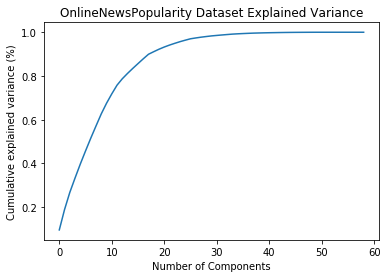

In [3]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance (%)') #for each component
plt.title('OnlineNewsPopularity Dataset Explained Variance')
plt.show()

In [4]:
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(data)
PCdata = pd.DataFrame(data = principalComponents,\
                           columns=['PC%s' %i for i in range(1,31)])

# Train models

### Decision Tree

In [14]:

def DecisionTreeModel(data, label):
    T0 = time.time()
    DecisionTree = DecisionTreeClassifier(random_state=0)
    DTscore = cross_val_score(DecisionTree, data, label, cv=10).mean()
    T1 = time.time() - T0
    print("Accuracy for Decision Tree:" + str(round(DTscore*100, 2)) + "%")
    print("Running time:" + str(round(T1, 2)))
    
print('**** After applied PCA ****')
DecisionTreePC = DecisionTreeModel(PCdata, label)
print('\n**** Before applied PCA ****')
DecisionTree = DecisionTreeModel(data, label)


**** After applied PCA ****
Accuracy for Decision Tree:73.06%
Running time:15.05

**** Before applied PCA ****
Accuracy for Decision Tree:73.35%
Running time:14.21


### Naive Bayes

In [15]:

def NaiveBayesModel(data, label):

    T0 = time.time()
    Bernoulli =  BernoulliNB()
    BernoulliScore = cross_val_score(Bernoulli, data, label, cv=10).mean()
    T1 = time.time() - T0
    T2 = time.time()
    Gaussian = GaussianNB()
    GaussianScore = cross_val_score(Gaussian, data, label, cv=10).mean()
    T3 = time.time() - T2
    
    print("Accuracy for Gaussian Naive Bayes:" + str(round(GaussianScore*100, 2)) + "%")
    print("Running time:" + str(round(T3, 2)))
    print("Accuracy for Bernoulli Naive Bayes:" + str(round(BernoulliScore*100, 2)) + "%")
    print("Running time:" + str(round(T1, 2)))

print('**** After applied PCA ****')
NaiveBayesPC = NaiveBayesModel(PCdata, label)
print('\n**** Before applied PCA ****')
NaiveBayes = NaiveBayesModel(data, label)

**** After applied PCA ****
Accuracy for Gaussian Naive Bayes:43.6%
Running time:0.7
Accuracy for Bernoulli Naive Bayes:44.09%
Running time:1.2

**** Before applied PCA ****
Accuracy for Gaussian Naive Bayes:42.03%
Running time:0.97
Accuracy for Bernoulli Naive Bayes:43.85%
Running time:1.4


### KNN

In [19]:

weights = ['uniform', 'distance']
K = [1,5,10]

def KNN_Model(data, label):
    KNN_dict = {}
    for k in K:
        KNNScores = []
        for weight in weights:
            T0 = time.time()
            KNN = KNeighborsClassifier(n_neighbors=k, weights=weight)
            KNNScore = cross_val_score(KNN, data, label, cv=10).mean()
            T1 = time.time() - T0
            KNNScores.append([str(round(KNNScore*100, 2)) + "%", str(round(T1, 2))])
        ind = str('K = ') + str(k)
        KNN_dict[ind] = KNNScores
    return KNN_dict
    

print('KNN Accuracy and running time with different weights and Ks')
print('\n**** After applied PCA ****')
KNN_dictPC = KNN_Model(PCdata, label)
KNN_resultPC = pd.DataFrame.from_dict(KNN_dictPC, orient='index', columns=weights)
display(KNN_resultPC)
print('\n**** Before applied PCA ****')
KNN_dict = KNN_Model(data, label)
KNN_result = pd.DataFrame.from_dict(KNN_dict, orient='index', columns=weights)
display(KNN_result)

KNN Accuracy and running time with different weights and Ks

**** After applied PCA ****


,uniform,distance
K = 1,"[73.36%, 7.33]","[73.36%, 7.94]"
K = 5,"[55.59%, 19.98]","[70.25%, 19.65]"
K = 10,"[51.47%, 23.63]","[70.03%, 24.64]"



**** Before applied PCA ****


,uniform,distance
K = 1,"[73.35%, 54.53]","[73.35%, 52.94]"
K = 5,"[56.02%, 108.65]","[70.41%, 104.11]"
K = 10,"[51.59%, 116.19]","[70.16%, 116.37]"


### SVM

In [20]:

def SVM_Model(data, label):
    T0 = time.time()
    Grid_Dict = {"C": [1e-2, 1e-1,1e0, 1e1, 1e2]}
    svc_Tuned = GridSearchCV(LinearSVC( tol = 0.005), \
                             cv=10,param_grid=Grid_Dict, scoring="accuracy")
    svc_Tuned.fit(data, label)
    SVC_accuracy = LinearSVC( C=svc_Tuned.best_params_['C'], tol = 0.01)
    SVC_Time = time.time() - T0
    Accuracys_SVC = cross_val_score(SVC_accuracy, data, label, cv=10, scoring="accuracy").mean()
    print("Accuracy for tuned SVM: " + str(round(Accuracys_SVC*100, 2)) + "%")
    print("Running time:" + str(round(SVC_Time, 2)))
    return Accuracys_SVC, svc_Tuned
    

print('**** After applied PCA ****')       
Accuracys_SVCPC, svc_TunedPC = SVM_Model(PCdata, label)
print('\n**** Before applied PCA ****')
Accuracys_SVC, svc_Tuned = SVM_Model(data, label)

svc_Tuned

**** After applied PCA ****
Accuracy for tuned SVM: 47.57%
Running time:446.17

**** Before applied PCA ****
Accuracy for tuned SVM: 49.26%
Running time:599.78


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.005,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
svc_Tuned

GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.005,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### Logistic Regression

In [23]:

solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
c_list = [1,5,10,15,20]

def LogisticRegressionModel(PCdata, label):
    LR_dict = {}
    for c in c_list:
        LR_scores = []
        for solver in solvers:
            T0 = time.time()
            LR = LogisticRegression(random_state=0, solver=solver, \
                                    multi_class='multinomial', C=c)
            LRScore = cross_val_score(LR, PCdata, label, cv=10).mean()
            T1 = time.time() - T0
            LR_scores.append([str(round(LRScore*100, 2)) + "%", str(round(T1, 2))])
        ind = str('C = ') + str(c)
        LR_dict[ind] = LR_scores
    return LR_dict

    
print('Logistic Regression Accuracy with different solvers and Cs')
print('\n**** After applied PCA ****')  
LR_dictPC = LogisticRegressionModel(PCdata, label)
LR_resultPC = pd.DataFrame.from_dict(LR_dictPC, orient='index', columns=solvers)
display(LR_resultPC)
print('\n**** Before applied PCA ****')
LR_dict = LogisticRegressionModel(data, label)
LR_result = pd.DataFrame.from_dict(LR_dict, orient='index', columns=solvers)
display(LR_result)

Logistic Regression Accuracy with different solvers and Cs

**** After applied PCA ****


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,newton-cg,sag,saga,lbfgs
C = 1,"[47.63%, 5.83]","[47.63%, 15.54]","[47.62%, 8.57]","[47.62%, 3.4]"
C = 5,"[47.63%, 5.91]","[47.63%, 25.53]","[47.63%, 9.27]","[47.63%, 3.43]"
C = 10,"[47.63%, 5.7]","[47.63%, 27.66]","[47.63%, 9.57]","[47.63%, 3.37]"
C = 15,"[47.63%, 5.73]","[47.63%, 28.97]","[47.63%, 9.49]","[47.63%, 3.4]"
C = 20,"[47.62%, 5.6]","[47.62%, 27.89]","[47.62%, 9.62]","[47.62%, 3.31]"



**** Before applied PCA ****


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

,newton-cg,sag,saga,lbfgs
C = 1,"[48.71%, 27.6]","[48.7%, 23.45]","[48.71%, 30.41]","[48.48%, 7.34]"
C = 5,"[49.1%, 46.06]","[49.09%, 31.15]","[49.1%, 53.28]","[48.48%, 7.76]"
C = 10,"[49.24%, 56.75]","[49.24%, 44.99]","[49.22%, 53.45]","[48.57%, 7.68]"
C = 15,"[49.29%, 66.59]","[49.29%, 46.85]","[49.28%, 53.66]","[48.62%, 7.64]"
C = 20,"[49.37%, 79.08]","[49.37%, 48.62]","[49.35%, 52.27]","[48.54%, 7.59]"


### Neural Network

In [5]:

hidden_layer_sizes = [(50,100,30),(300,50,30),(200,100,50),(150,100,50),(200,50)]

def NeuralNetworkModel(data, label):
    NN_dict = {}
    
    for layer_size in hidden_layer_sizes:
        T0 = time.time()
        NN = MLPClassifier(solver='adam', hidden_layer_sizes=layer_size, random_state=1)
        NNScore = cross_val_score(NN, data, label, cv=10).mean()
        T1 = time.time() - T0
        NN_scores = [str(round(NNScore*100, 2)) + "%", str(round(T1, 2))]
        ind = str(layer_size) + str(' hidden layers')
        NN_dict[ind] = NN_scores
    return NN_dict


print('Neural Network scores with different hidden layer sizes')
print('\n**** After applied PCA ****') 
NN_dictPC = NeuralNetworkModel(PCdata, label)
NN_resultPC = pd.DataFrame.from_dict(NN_dictPC, orient='index')
display(NN_resultPC)
print('\n**** Before applied PCA ****')
NN_dict = NeuralNetworkModel(data, label)
NN_result = pd.DataFrame.from_dict(NN_dict, orient='index')
display(NN_result)

Neural Network scores with different hidden layer sizes

**** After applied PCA ****


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,0,1
"(50, 100, 30) hidden layers",60.19%,270.36
"(300, 50, 30) hidden layers",66.29%,273.49
"(200, 100, 50) hidden layers",69.01%,306.01
"(150, 100, 50) hidden layers",67.91%,322.75
"(200, 50) hidden layers",63.09%,344.71



**** Before applied PCA ****


,0,1
"(50, 100, 30) hidden layers",58.84%,379.76
"(300, 50, 30) hidden layers",66.9%,506.89
"(200, 100, 50) hidden layers",68.23%,393.85
"(150, 100, 50) hidden layers",67.51%,416.05
"(200, 50) hidden layers",61.54%,339.15


### Random Forest

In [6]:

def RandomForestModel(PCdata, label):
    RF_dict = {}
    for n_estimator in range(50, 151, 50):
        RF_scores = []
        for maxDepth in range(5,26,5):
            T0 = time.time()
            RandomForest = RandomForestClassifier(n_estimators=n_estimator,\
                                          max_depth=maxDepth,random_state=0)
            RFScore = cross_val_score(RandomForest, PCdata, label, cv=10).mean()

            T1 = time.time() - T0
            RF_scores.append([str(round(RFScore*100, 2)) + "%", str(round(T1, 2))])
        ind = str(n_estimator) + str(' estimators')
        RF_dict[ind] = RF_scores
    return RF_dict

print('Random Forest scores with different number of trees in the forest',\
      'and maximum depths of the tree')
print('\n**** After applied PCA ****') 
RF_dictPA = RandomForestModel(PCdata, label)
RF_resultPA = pd.DataFrame.from_dict(RF_dictPA, orient='index', columns=[5,10,15,20,25])
display(RF_resultPA)
print('\n**** Before applied PCA ****')
RF_dict = RandomForestModel(data, label)
RF_result = pd.DataFrame.from_dict(RF_dict, orient='index', columns=[5,10,15,20,25])
display(RF_result)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Random Forest scores with different number of trees in the forest and maximum depths of the tree

**** After applied PCA ****


,5,10,15,20,25
50 estimators,"[48.59%, 32.08]","[58.96%, 54.62]","[72.55%, 73.18]","[77.15%, 84.63]","[78.19%, 89.84]"
100 estimators,"[48.54%, 61.41]","[59.19%, 108.99]","[73.11%, 147.87]","[77.71%, 160.5]","[78.72%, 167.96]"
150 estimators,"[48.42%, 88.88]","[59.24%, 157.7]","[73.34%, 210.18]","[77.95%, 240.16]","[79.0%, 251.89]"



**** Before applied PCA ****


,5,10,15,20,25
50 estimators,"[50.09%, 21.06]","[60.78%, 36.47]","[75.07%, 49.44]","[78.65%, 56.66]","[79.61%, 58.94]"
100 estimators,"[50.22%, 40.77]","[61.27%, 71.57]","[75.49%, 97.58]","[79.22%, 114.87]","[80.26%, 116.42]"
150 estimators,"[50.24%, 61.26]","[61.52%, 108.66]","[75.93%, 146.48]","[79.69%, 167.89]","[80.52%, 174.12]"


## Import test dataset

In [9]:
test_dataset = pd.read_csv("train_set.csv")
test_X = test_dataset.loc[:, test_dataset.columns != 'shares']
test_Y = test_dataset.loc[:, 'shares'].values


PCtest = pca.fit_transform(test_X)
PCtest_data = pd.DataFrame(data = PCtest,\
                           columns=['PC%s' %i for i in range(1,31)])

In [25]:
def Model_Test(train_X, label, test_X, test_Y, model):
    T0 = time.time()
    model_chosen = model
    model_chosen.fit(train_X, label)
    y_pred = model_chosen.predict(train_X)
    train_score = accuracy_score(label, y_pred)
    
    print('\nTraining Accuracy: '+ str(round(train_score*100, 2)) + "%")
    
    # Get the confusion matrix of training set


    confusion_matrix_train = confusion_matrix(label, y_pred, \
                                              labels=['Low Popularity', \
                                                      'Intermediate Popularity', \
                                                      'High Popularity'])
    print('Train Confusion Matrix')
    print(confusion_matrix_train)
    
    T1 = time.time() - T0
    print("\nRunning time is: " + str(round(T1, 2)))


    # Get test accuracy
    y_pred_test = model_chosen.predict(test_X)
    test_score = accuracy_score(test_Y, y_pred_test)
    print('\nTesting Accuracy: '+ str(round(test_score*100, 2)) + "%")

    confusion_matrix_test = confusion_matrix(test_Y, y_pred_test, \
                                              labels=['Low Popularity', \
                                                      'Intermediate Popularity', \
                                                      'High Popularity'])
    print('Test Confusion Matrix')
    print(confusion_matrix_test)

## Max Voting

In [26]:
NB = BernoulliNB()
KNNTest = Model_Test(data, label, test_X, test_Y, NB)


Training Accuracy:43.87%
Train Confusion Matrix
[[9107 2635 1972]
 [5959 4697 3058]
 [5321 4147 4246]]

Running time is:0.23

Testing Accuracy:45.38%
Test Confusion Matrix
[[7742 2265 1743]
 [5959 4697 3058]
 [2420 1879 1952]]


In [27]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNNTest = Model_Test(data, label, test_X, test_Y, KNN)


Training Accuracy:100.0%
Train Confusion Matrix
[[13714     0     0]
 [    0 13714     0]
 [    0     0 13714]]

Running time is:8.87

Testing Accuracy:91.24%
Test Confusion Matrix
[[ 9492  1722   536]
 [    0 13714     0]
 [  153   367  5731]]


In [28]:
SVM = LinearSVC( C=1, tol = 0.005)
SVMTest = Model_Test(data, label, test_X, test_Y, SVM)


Training Accuracy:49.23%
Train Confusion Matrix
[[8976 2276 2462]
 [5141 4158 4415]
 [3590 3005 7119]]

Running time is:6.09

Testing Accuracy:47.53%
Test Confusion Matrix
[[7674 1944 2132]
 [5141 4158 4415]
 [1653 1357 3241]]


In [29]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=15)
LRTest = Model_Test(data, label, test_X, test_Y, LR)


Training Accuracy:48.81%
Train Confusion Matrix
[[8522 2820 2372]
 [4754 4882 4078]
 [3344 3694 6676]]

Running time is:1.01

Testing Accuracy:47.96%
Test Confusion Matrix
[[7297 2394 2059]
 [4754 4882 4078]
 [1548 1673 3030]]


In [30]:
NN = MLPClassifier(solver='adam', hidden_layer_sizes=(200, 100, 50), random_state=1)
NNTest = Model_Test(data, label, test_X, test_Y, NN)



Training Accuracy:92.0%
Train Confusion Matrix
[[12304  1224   186]
 [  980 12144   590]
 [   57   256 13401]]

Running time is:69.46

Testing Accuracy:82.33%
Test Confusion Matrix
[[ 8391  2572   787]
 [  980 12144   590]
 [  176   500  5575]]


In [31]:
RF = RandomForestClassifier(n_estimators=100,max_depth=25,random_state=0)
RFTest = Model_Test(data, label, test_X, test_Y, RF)



Training Accuracy:99.99%
Train Confusion Matrix
[[13714     0     0]
 [    4 13710     0]
 [    1     0 13713]]

Running time is:14.79

Testing Accuracy:91.81%
Test Confusion Matrix
[[ 9711  1806   233]
 [    4 13710     0]
 [   91   464  5696]]


In [32]:
DT = DecisionTreeClassifier(random_state=0)
DTTest = Model_Test(data, label, test_X, test_Y, DT)


Training Accuracy:100.0%
Train Confusion Matrix
[[13714     0     0]
 [    0 13714     0]
 [    0     0 13714]]

Running time is:1.69

Testing Accuracy:91.31%
Test Confusion Matrix
[[ 9488  1693   569]
 [    0 13714     0]
 [  155   338  5758]]


In [39]:
model = VotingClassifier(estimators=[('rf', RF), ('knn', KNN), ('nn', NN),\
                                     ('dt', DT), ('nb', NB), \
                                     ('lr', LR)], voting='soft')
model.fit(data, label)
pred_test = model.predict(test_X)
max_voting_score = model.score(test_X, test_Y)
print("Accuracy with max voting algorithm: " + str(round(max_voting_score*100, 2)) + "%")
confusion_matrix_test = confusion_matrix(test_Y, pred_test, \
                                         labels=['Low Popularity', \
                                                 'Intermediate Popularity', \
                                                 'High Popularity'])
print('Test Confusion Matrix')
print(confusion_matrix_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy with max voting algorithm: 92.09%
Test Confusion Matrix
[[ 9741  1628   381]
 [    0 13714     0]
 [  130   370  5751]]


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
